In [318]:
#Step 1: Import libraries
import os
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime as dt
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
import pmdarima as pm
from pmdarima import auto_arima
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pylab import rcParams
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
import warnings
warnings.filterwarnings('ignore')


In [360]:
#Step 2: Import ARIMA package
!pip install pmdarima

In [361]:
#Step 3: Import data
os.chdir("C:\\Users\\melis\\Documents\\DSC-570 Data Mining")

train_test = pd.read_csv("DATASET.csv")

TRAIN = train_test[:133316]
                         
TEST = train_test[133316:]

TRAIN.head()

,Date,Sales
0,1/1/2016,418.5104
1,1/1/2016,744.6912
2,1/1/2016,617.5488
3,1/1/2016,632.6848
4,1/1/2016,1008.0576


In [362]:
#Step 4: Make sure types are correct
TRAIN['Sales']=TRAIN['Sales'].astype('int')
TRAIN['Date']=TRAIN['Date'].astype('datetime64[ns]')

TEST['Sales']=TEST['Sales'].astype('int')
TEST['Date']=TEST['Date'].astype('datetime64[ns]')

In [363]:
TRAIN.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133316 entries, 0 to 133315
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   Date    133316 non-null  datetime64[ns]
 1   Sales   133316 non-null  int32         
dtypes: datetime64[ns](1), int32(1)
memory usage: 1.5 MB


In [364]:
TEST.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41874 entries, 133316 to 175189
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    41874 non-null  datetime64[ns]
 1   Sales   41874 non-null  int32         
dtypes: datetime64[ns](1), int32(1)
memory usage: 490.8 KB


In [365]:
#Step 5: Create Index
TRAIN = TRAIN.set_index('Date')
TRAIN.index

DatetimeIndex(['2016-01-01', '2016-01-01', '2016-01-01', '2016-01-01',
               '2016-01-01', '2016-01-01', '2016-01-01', '2016-01-01',
               '2016-01-01', '2016-01-01',
               ...
               '2020-12-01', '2020-12-01', '2020-12-01', '2020-12-01',
               '2020-12-01', '2020-12-01', '2020-12-01', '2020-12-01',
               '2020-12-01', '2020-12-01'],
              dtype='datetime64[ns]', name='Date', length=133316, freq=None)

In [366]:
TEST = TEST.set_index('Date')
TEST.index

DatetimeIndex(['2021-01-01', '2021-01-01', '2021-01-01', '2021-01-01',
               '2021-01-01', '2021-01-01', '2021-01-01', '2021-01-01',
               '2021-01-01', '2021-01-01',
               ...
               '2021-11-01', '2021-11-01', '2021-11-01', '2021-11-01',
               '2021-11-01', '2021-11-01', '2021-11-01', '2021-11-01',
               '2021-11-01', '2021-11-01'],
              dtype='datetime64[ns]', name='Date', length=41874, freq=None)

In [367]:
#Step 6: Group data
TRAIN = TRAIN['Sales'].resample('MS').mean()

In [368]:
TEST = TEST['Sales'].resample('MS').mean()

Text(0, 0.5, 'Sales (Millions)')

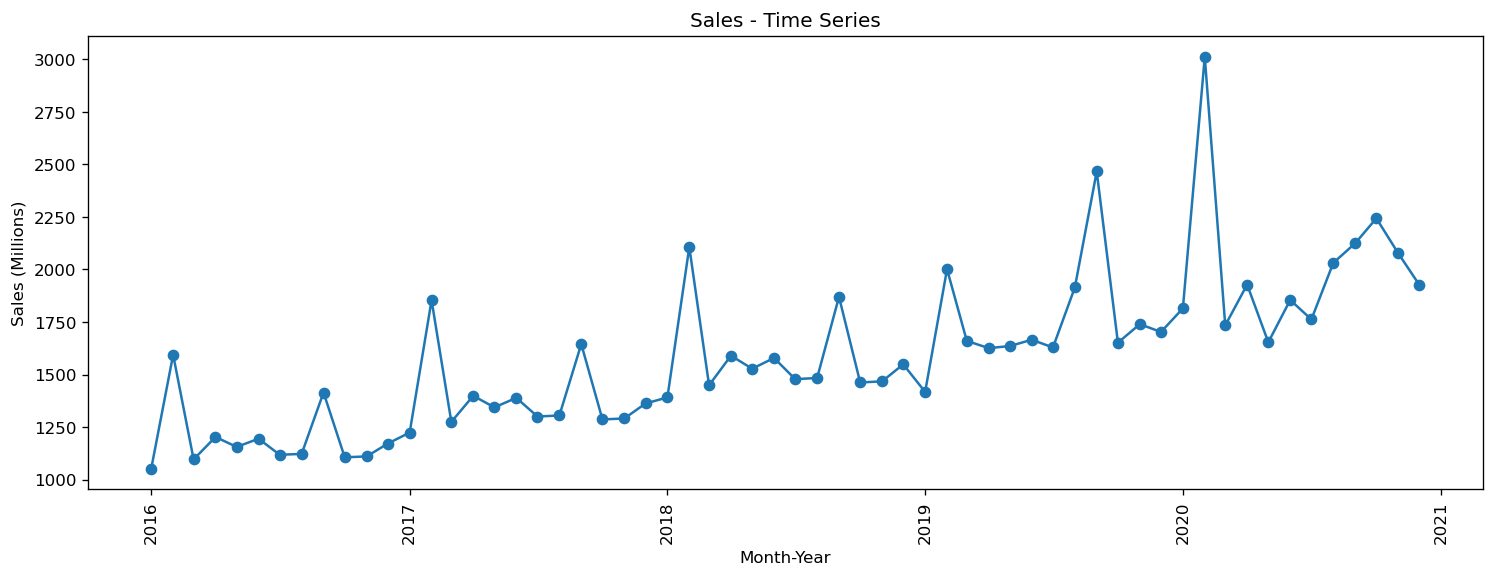

In [369]:
#Step 7: Visulize data
plt.figure(figsize=(15,5))
plt.plot(TRAIN, marker = 'o')
plt.title("Sales - Time Series")
plt.xticks(rotation='vertical')
plt.xlabel("Month-Year")
plt.ylabel("Sales (Millions)")

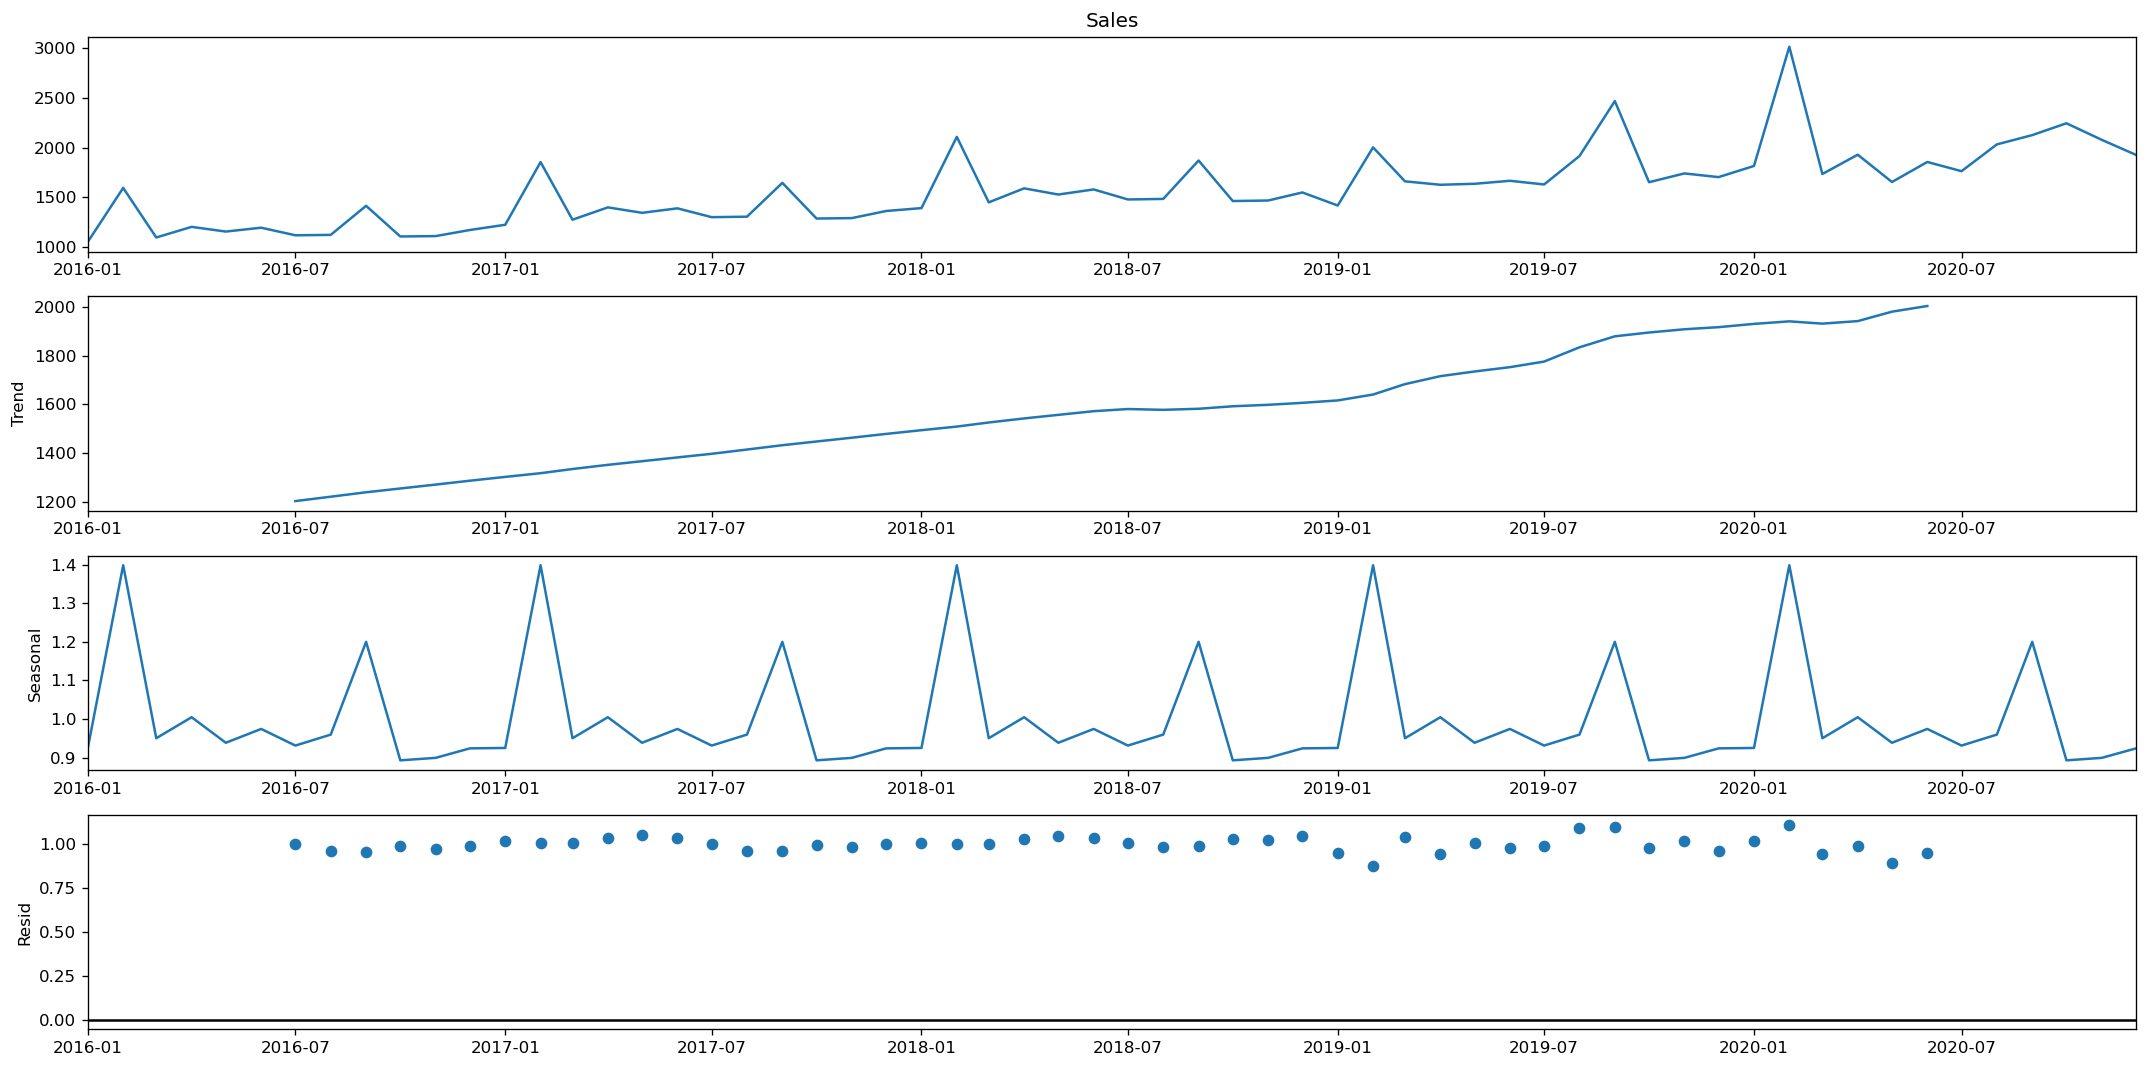

In [328]:
#Step 8: Visulize trend and seasonal plots - mult

rcParams['figure.figsize'] = (18, 9)

decomposition = seasonal_decompose(TRAIN, model = 'multiplicative', period = 12)
decomposition.plot()

plt.show()

In [329]:
#Step 9: Optional Visualization
data = pd.read_csv('monthly.csv')
data.head()

,Month,2016,2017,2018,2019,2020
0,1,1947728.883,2264801.026,2573637.53,2848747.36,3202056.491
1,2,2232275.231,2595668.874,2949623.72,4136655.05,4208977.816
2,3,1524108.690,1772219.407,2013885.69,2329021.08,2421246.793
3,4,1881804.496,2188144.763,2486528.14,2774930.70,2931127.368
4,5,3702776.152,4305553.666,4892674.62,3625950.71,3756125.278


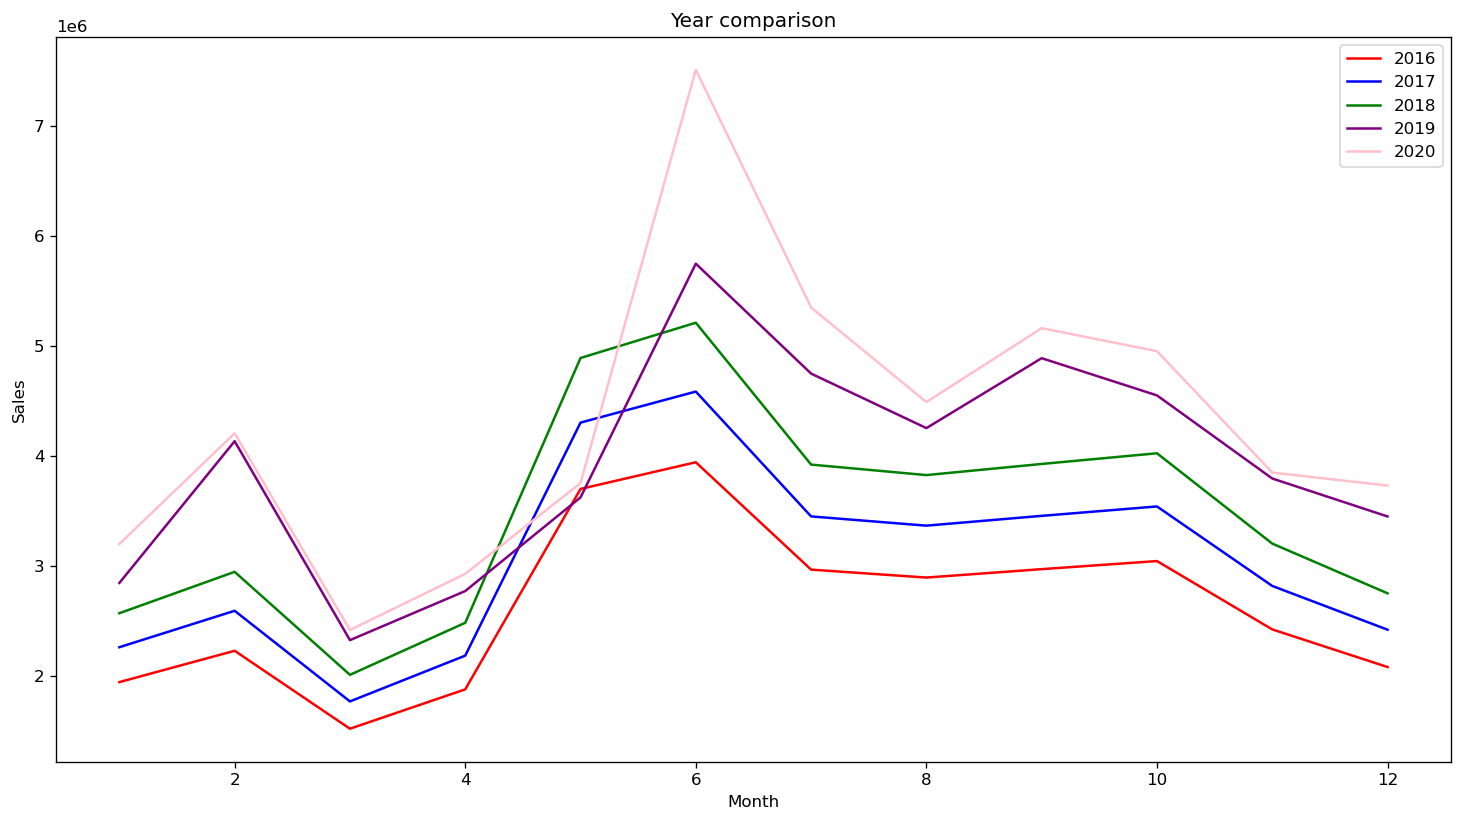

In [330]:
plt.figure(figsize=(15,8))
plt.plot(data['Month'], data['2016'], label="2016", color = 'red')
plt.plot(data['Month'], data['2017'], label="2017",color = 'blue')
plt.plot(data['Month'], data['2018'], label="2018",color = 'green')
plt.plot(data['Month'], data['2019'], label="2019",color = 'purple')
plt.plot(data['Month'], data['2020'], label="2020",color = 'pink')
plt.title("Year comparison")
plt.xlabel("Month")
plt.ylabel("Sales")
plt.legend()
plt.show()

In [331]:
#Step 10: Test for stationary with Dickey Fuller Test
result = adfuller(TRAIN, autolag='AIC')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: 0.535881
p-value: 0.985924


In [332]:
#If the p-value is greater than .05 we know that our data is not-stationary and it needs to be 
#in order to run ARIMA model

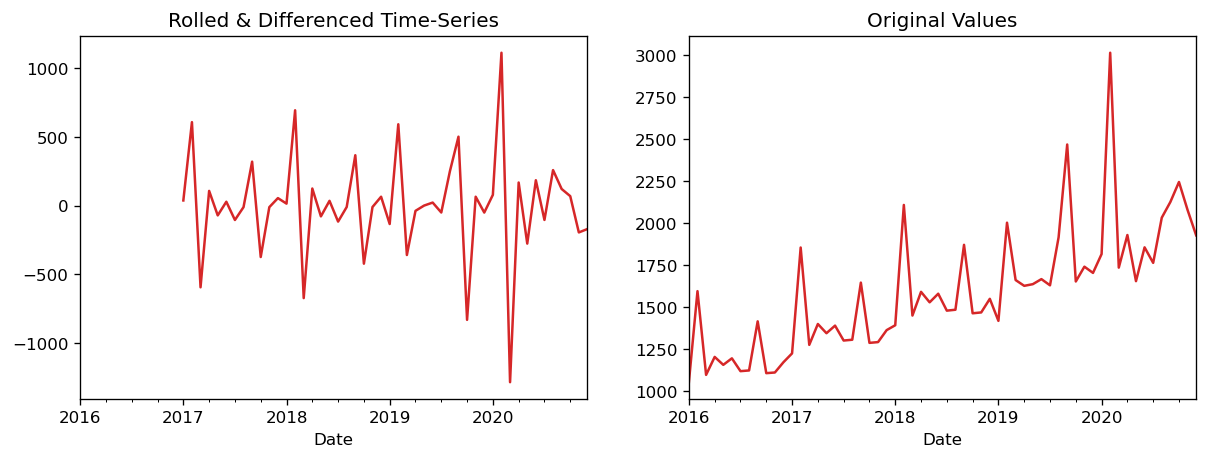

In [334]:
#Step 11: Difference over log transformed & mean rolled
rolling_mean = TRAIN.rolling(window = 12).mean()
sales_detrended = TRAIN - rolling_mean

sales_rolled_detrended_diff = sales_detrended - sales_detrended.shift()

ax1 = plt.subplot(121)
sales_rolled_detrended_diff.plot(figsize=(8,4), color="tab:red", title="Rolled & Differenced Time-Series", ax=ax1);
ax2 = plt.subplot(122)
TRAIN.plot(figsize=(12,4), color="tab:red", title="Original Values", ax=ax2);

In [335]:
datatest = adfuller(sales_rolled_detrended_diff.dropna(), autolag = 'AIC')

print('ADF Statistic: %f' % datatest[0])
print('p-value: %f' % datatest[1])

ADF Statistic: -4.553068
p-value: 0.000157


In [336]:
#now the p-value is below 0.05, so the data is stationary!

In [340]:
#Step 12: Fit auto_arima function to dataset
auto_model = auto_arima(TRAIN, start_p = 1, start_q = 1,
                          max_p = 3, max_q = 3, m = 12,
                          start_P = 0, seasonal = True,
                          d = None, D = 1, trace = True,
                          error_action ='ignore',   # we don't want to know if an order does not work
                          suppress_warnings = True,  # we don't want convergence warnings
                          stepwise = True)           # set to stepwise

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=636.757, Time=0.69 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=641.335, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=634.735, Time=0.79 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=634.764, Time=0.68 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=677.725, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=643.279, Time=0.04 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=635.459, Time=1.62 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=635.481, Time=1.50 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=634.748, Time=0.69 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=637.609, Time=1.44 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=632.931, Time=0.47 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=633.760, Time=1.21 sec
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=633.772, Time=1.11 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=632.907, Time=0.58 sec
 ARIMA(0,0,0)(0,1,2)[12] intercep

In [ ]:
#Step 13: Continue to run for SARIMAX if data is not stationary 
model = SARIMAX(TRAIN, 
                order = (0, 0, 0), 
                seasonal_order =(0, 1, 1, 12))
  
model_fit = model.fit()

In [341]:
#Step 14: auto_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 SARIMAX Results                                  
==================================================================================
Dep. Variable:                          y   No. Observations:                   60
Model:             SARIMAX(0, 1, [1], 12)   Log Likelihood                -313.454
Date:                    Mon, 29 Nov 2021   AIC                            632.907
Time:                            18:16:26   BIC                            638.521
Sample:                                 0   HQIC                           635.028
                                     - 60                                         
Covariance Type:                      opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    204.0576     15.542     13.129      0.000     173.596     234.519
ma.S.L12      -0.6742      0.284     -2.376      0.018      -1.230      -0.118
sigma2      2.384e+04   6406.833      3.721      0.000    1.13e+04    3.64e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.18   Jarque-Bera (JB):                82.49
Prob(Q):                              0.68   Prob(JB):                         0.00
Heteroskedasticity (H):              59.14   Skew:                             1.78
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [370]:
# Step 15: model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 SARIMAX Results                                  
==================================================================================
Dep. Variable:                      Sales   No. Observations:                   60
Model:             SARIMAX(0, 1, [1], 12)   Log Likelihood                -335.759
Date:                    Mon, 29 Nov 2021   AIC                            675.519
Time:                            20:00:36   BIC                            679.261
Sample:                        01-01-2016   HQIC                           676.933
                             - 12-01-2020                                         
Covariance Type:                      opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L12       0.3007      0.240      1.251      0.211      -0.170       0.772
sigma2       6.96e+04   1.04e+04      6.711      0.000    4.93e+04    8.99e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.11   Jarque-Bera (JB):               145.78
Prob(Q):                              0.74   Prob(JB):                         0.00
Heteroskedasticity (H):               5.89   Skew:                             1.24
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.17
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

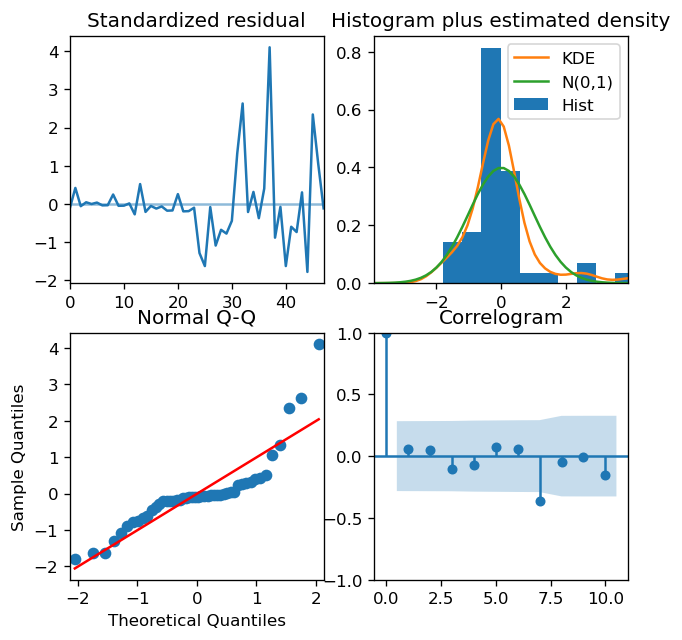

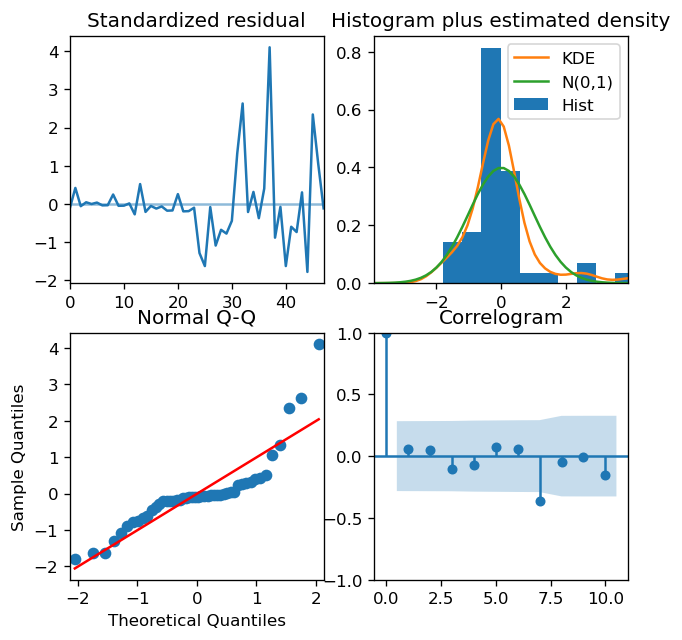

In [342]:
#Step 16: Look at auto model plots
auto_model.plot_diagnostics(figsize=(6,6))

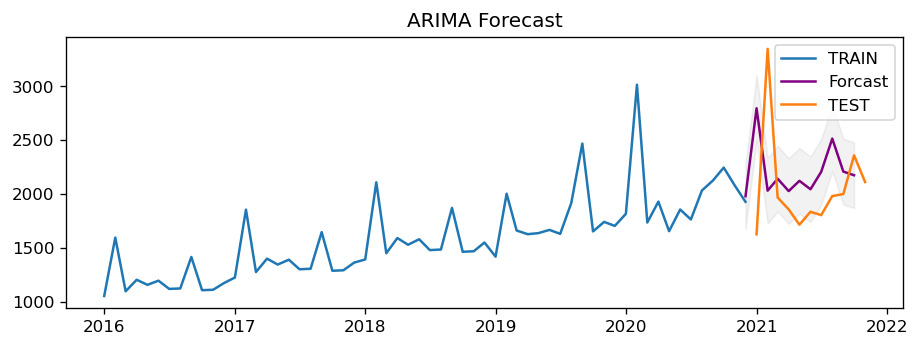

In [373]:
#Step 17: Validating forcasting for auto ARIMA
n_periods = 11
fitted, confidence = auto_model.predict(n_periods=n_periods, return_conf_int=True)
index_fc = pd.date_range(TRAIN.index[-1], periods=n_periods, freq='MS')
# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confidence[:, 0], index=index_fc)
upper_series = pd.Series(confidence[:, 1], index=index_fc)

# Plot
plt.plot(TRAIN, label="TRAIN")
plt.plot(fitted_series, color='Purple', label = "Forcast")
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.05)
plt.plot(TEST, label= "TEST")
plt.legend()
plt.title("ARIMA Forecast")
plt.show()

<AxesSubplot:xlabel='Date'>

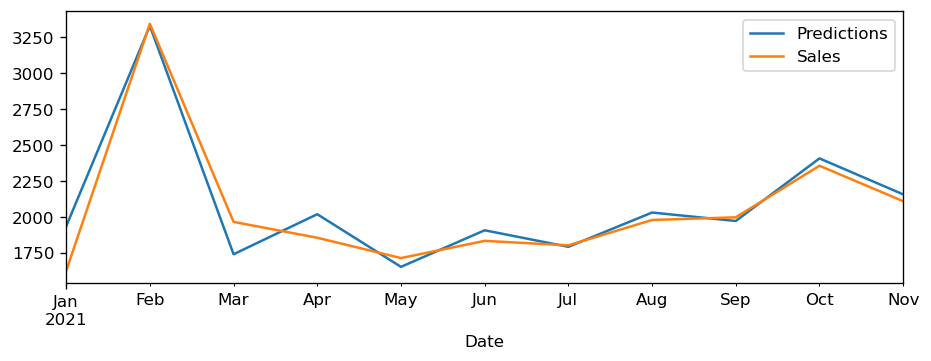

In [347]:
#Step 18: Plotting predictions and actual values for SARIMA
start = len(TRAIN)
end = len(TRAIN) + len(TEST) - 1
  
predictions = model_fit.predict(start, end,
                             typ = 'levels').rename("Predictions")
  
predictions.plot(legend = True)
TEST.plot(legend = True)

<AxesSubplot:xlabel='Date'>

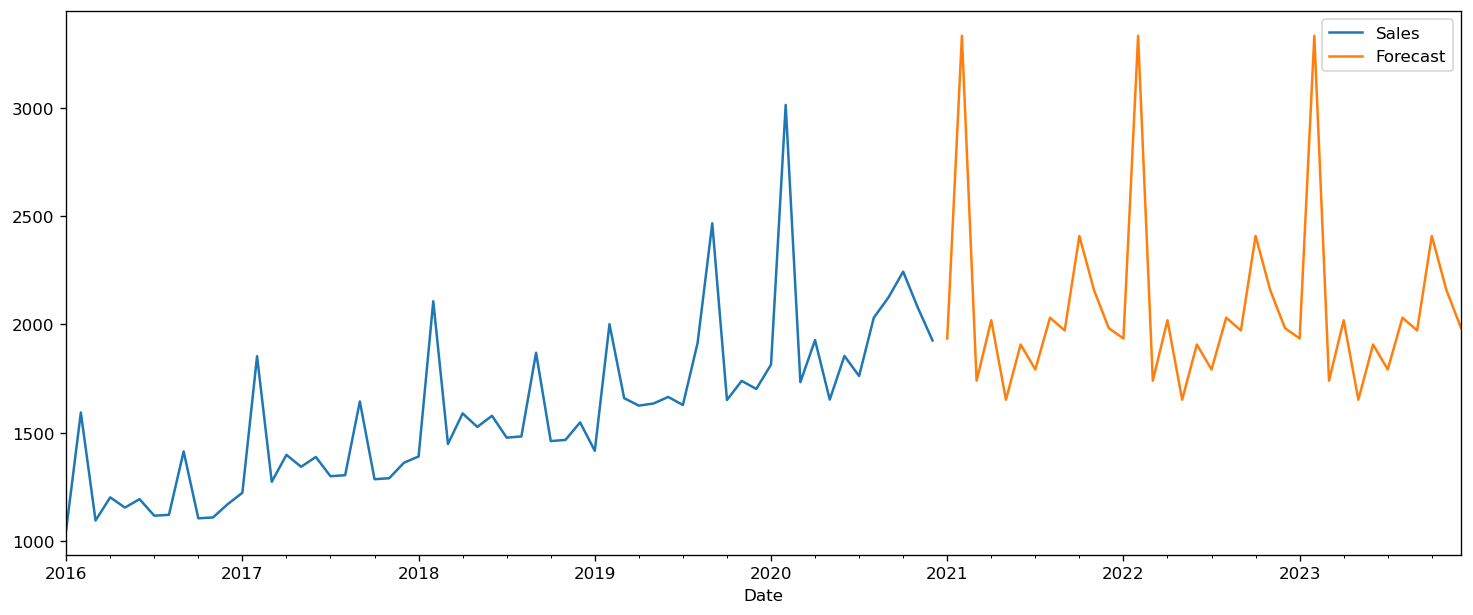

In [374]:
#Step 19: Forecast for the next 3 years
forecast = model_fit.predict(start = len(TRAIN), 
                          end = (len(TRAIN)-1) + 3 * 12, 
                          typ = 'levels').rename('Forecast')

TRAIN.plot(figsize = (15, 6), legend = True)
forecast.plot(legend = True)

In [355]:
#Step 20:Find actual error
mape = np.mean(np.abs(predictions - TEST)/np.abs(TEST))
mape

0.051191787980874266

In [356]:
#The MAPE is 5% meaning out model is 95% accurare in predicting sales for the nect year